In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib widget
import os
import sys
import importlib
import glob
from scipy.signal import find_peaks


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tools
import math_functions as mf
import BodeClass as bc

importlib.reload(tools)
importlib.reload(mf)
importlib.reload(bc)

folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Apresentaçoes/Experiments"

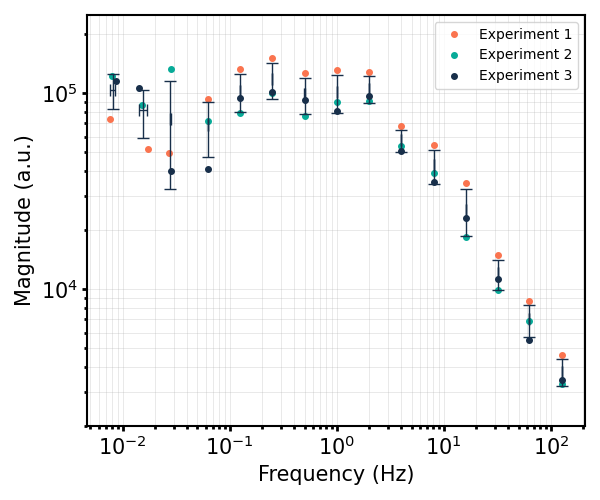

In [2]:
frequency_list = [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128][::-1]
names = ["20230720_bode", "20230721_bode", "20230724_bode" ]

line = 2.5
marker = 4

orange = [250/255, 116/255, 79/255]
green = [7/255, 171/255, 152/255]
blue = [24/255, 47/255, 74/255]

colors = [orange, green, blue] 

replicates = []
frequencies = []
amplitudes = []

for i, name in enumerate(names):
    replicates.append(bc.BodeClass(name, "6-20", frequency_list, median_filtering_windos_size = 1, padding = True, padding_value = 2000, pic_search_window = 5))
    frequencies.append(replicates[i].fund_freq)
    amplitudes.append(replicates[i].fund_amp)
    
avg_freq = np.mean(frequencies, axis = 0)
avg_amp = np.mean(amplitudes, axis = 0)
std_freq = np.std(frequencies, axis = 0)
std_amp = np.std(amplitudes, axis = 0)

fig, ax = plt.subplots(figsize=(6,5))
fig_title = "Bode plot of the fundamental harmonic"

for i in range(len(names)):
    ax.plot(frequencies[i], amplitudes[i], "o", markersize=marker, color = colors[i], label = f"Experiment {i+1}")
ax.errorbar(avg_freq, avg_amp, xerr=std_freq, fmt ='', linestyle = '', linewidth = 1, yerr=std_amp, capsize=4, color = blue)

ax = tools.bode_plot_axes(ax)

ax.set_ylim(2e3, 2.5e5)

fig.tight_layout()

fig.savefig(f"{folder}/bode_replicates.png", dpi=300)

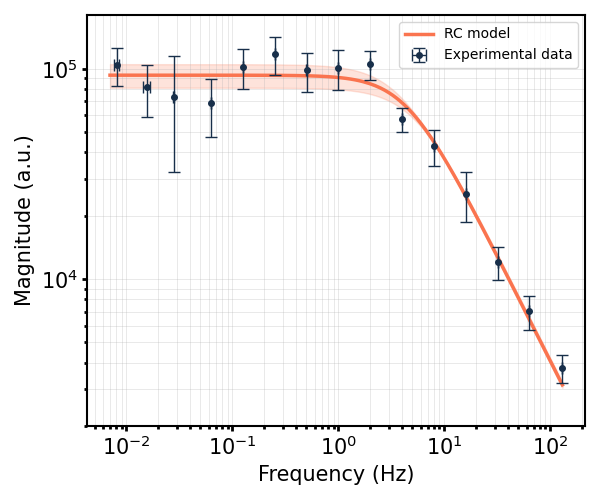

In [3]:
popt_RC, pcov_RC, ffit_RC, afit_RC = tools.RC_transf_fit(avg_freq, avg_amp, 0.007, 130, 1000, p0 =  [10, 0.1], sigma = std_amp)


fig, ax = plt.subplots(figsize=(6,5))
fig_title = "Bode plot of the fundamental harmonic"
ax.plot(ffit_RC, afit_RC, linewidth=line, color = orange, label = "RC model")
ax.errorbar(avg_freq, avg_amp, xerr=std_freq, fmt ='o', markersize = marker, linestyle = '', linewidth = 1, yerr=std_amp, capsize=4, color = blue, label = "Experimental data")

def my_err_vec(x, pcov):
    gradvec=np.array([x,1])
    norm=np.matmul(gradvec.T,np.matmul(pcov,gradvec))
    lambd=np.sqrt(1/norm)
    return np.matmul(pcov,lambd*gradvec)

RC_err_neg=[mf.RC_transfer(x,*(popt_RC-2*my_err_vec(x, pcov_RC))) for x in ffit_RC]
RC_err_pos=[mf.RC_transfer(x,*(popt_RC+2*my_err_vec(x, pcov_RC)))for x in ffit_RC]

ax.fill_between(np.linspace(0.007, 130, 1000), RC_err_neg, RC_err_pos, alpha=0.2, color = orange)

ax = tools.bode_plot_axes(ax)
ax.set_ylim(2e3, 1.8e5)

fig.tight_layout()
fig.savefig(f"{folder}/bode_model.png", dpi=300)

In [4]:
old_frequency_list = [0.0078125, 0.015625, 0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32]
old_recs = "37, 36, 35, 34, 33, 32, 31, 11, 41, 42, 45, 49, 51"
old_bode = bc.BodeClass("20230519_WT4A_ECS_bode", old_recs, old_frequency_list, 
                        median_filtering_windos_size = 1, padding = True, padding_value = 2000, pic_search_window = 5)


In [58]:
old_bode

NameError: name 'old_bode' is not defined

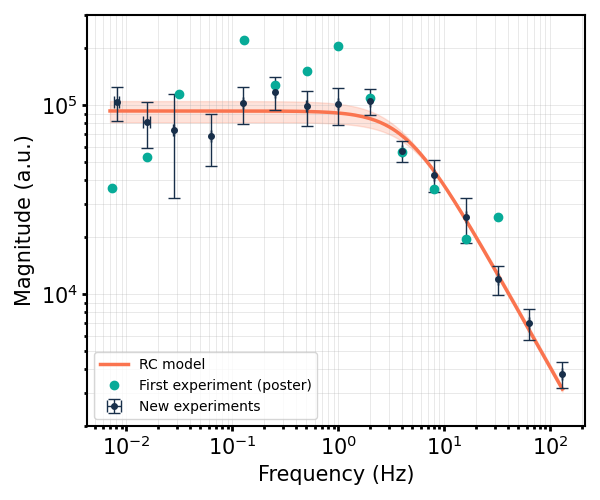

In [5]:




popt_RC, pcov_RC, ffit_RC, afit_RC = tools.RC_transf_fit(avg_freq, avg_amp, 0.007, 130, 1000, p0 =  [10, 0.1], sigma = std_amp)


fig, ax = plt.subplots(figsize=(6,5))
fig_title = "Bode plot of the fundamental harmonic"
ax.plot(ffit_RC, afit_RC, linewidth=line, color = orange, label = "RC model")
ax.errorbar(avg_freq, avg_amp, xerr=std_freq, fmt ='o', markersize = marker, linestyle = '', linewidth = 1, yerr=std_amp, capsize=4, color = blue, label = "New experiments")
ax.plot(old_bode.fund_freq, old_bode.fund_amp, 'o', markersize = 6, linewidth = 1, color = green, label = "First experiment (poster)")

RC_err_neg=[mf.RC_transfer(x,*(popt_RC-2*tools.my_err_vec(x, pcov_RC))) for x in ffit_RC]
RC_err_pos=[mf.RC_transfer(x,*(popt_RC+2*tools.my_err_vec(x, pcov_RC)))for x in ffit_RC]

ax.fill_between(np.linspace(0.007, 130, 1000), RC_err_neg, RC_err_pos, alpha=0.2, color = orange)

ax = tools.bode_plot_axes(ax)
#ax.set_ylim(2e3, 1.8e5)

fig.tight_layout()
fig.savefig(f"{folder}/bode_model_compare.png", dpi=300)

In [37]:
my_err_vec(1, pcov_RC)

array([ 5.97204659e+03, -3.81575534e-08])

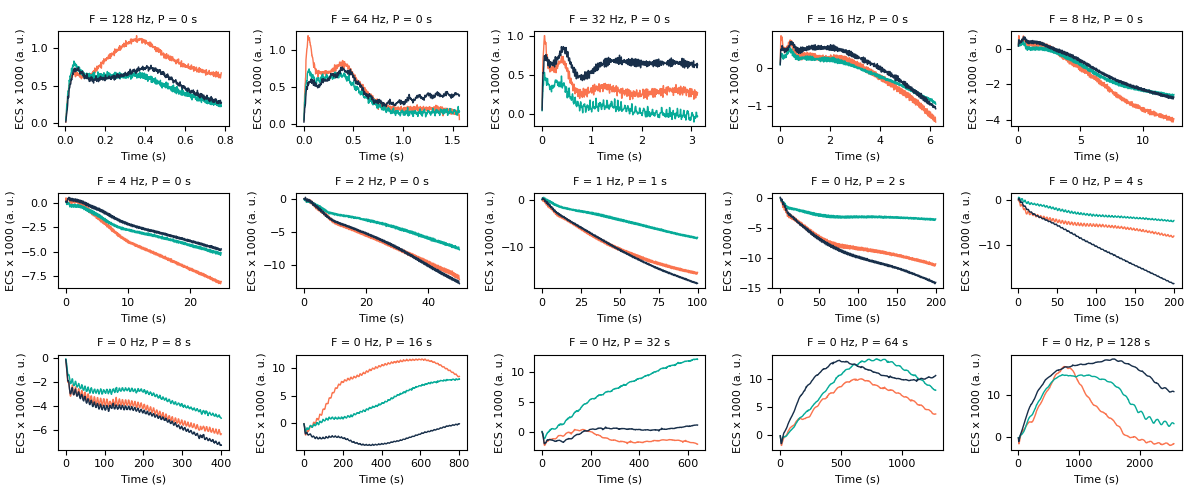

In [6]:
fig, ax = plt.subplots(3,5,figsize=(12,5))
ax = ax.flatten()
aux = 0
for j, frequency in enumerate(frequency_list):
    for i, name in enumerate(names):
        ax[aux].plot(replicates[i].bode_times[j]/1000, replicates[i].bode_data[j]/1000, linewidth=1, color = colors[i], label = f"Experiment {i+1}")
    ax[aux].set_title(f"F = {frequency:.0f} Hz, P = {1/frequency:.0f} s", fontsize = 8)
    ax[aux].set_xlabel("Time (s)", fontsize = 8)
    ax[aux].set_ylabel("ECS x 1000 (a. u.)", fontsize = 8)
    ax[aux].tick_params(axis='both', which='major', labelsize=8)
    aux = aux + 1
fig.tight_layout()

fig.savefig(f"{folder}/bode_time.png", dpi=300)

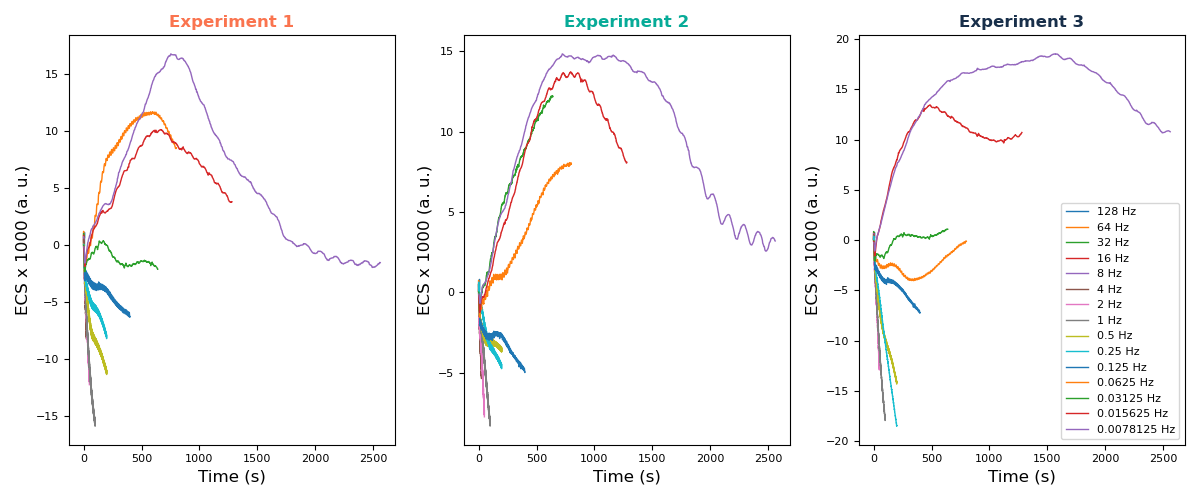

In [82]:
fig, ax = plt.subplots(1,3,figsize=(12,5))
ax = ax.flatten()
for i, name in enumerate(names):
    for j, frequency in enumerate(frequency_list):
        ax[i].plot(replicates[i].bode_times[j]/1000, replicates[i].bode_data[j]/1000, linewidth=1, label = f"{frequency} Hz")
    ax[i].set_title(f"Experiment {i+1}", fontsize = 12, color = colors[i], fontweight = "bold")
    ax[i].set_xlabel("Time (s)", fontsize = 12)
    ax[i].set_ylabel("ECS x 1000 (a. u.)", fontsize = 12)
    ax[i].tick_params(axis='both', which='major', labelsize=8)
ax[2].legend(fontsize = 8)
fig.tight_layout()

fig.savefig(f"{folder}/bode_derive.png", dpi=300)